In [1]:
# Imports
import torch
import torch.nn as nn
torch.cuda.empty_cache()

from utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = get_input_transform(520, IMG_SIZE)

In [2]:
from high_res import HighResDV2
shifts = [1, 3, 5, 7]
net = HighResDV2("dinov2_vits14", shifts, pattern="Moore", dtype=torch.float32, pca_each=True)
net.cuda()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
plane_tensor, plane_img = load_image("data/plane.jpg", transform)
plane_tensor = plane_tensor.to('cuda')

Here we visualise the data processing/pixel shift by looking at the last pixel shift image and subtracting the original - depending on which neighbourhood is used (Neumann vs Moore) this shoould highlight either vertical gradients or diagonal gradients.

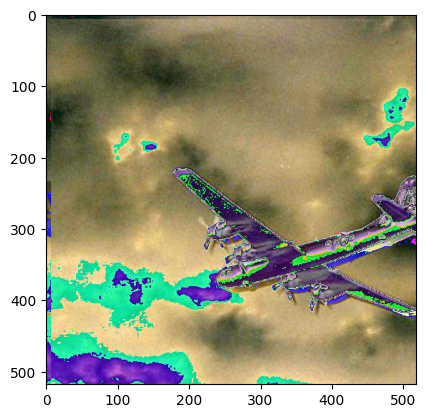

In [4]:
shifted_img_tensors = net.get_shifted_img_batch(plane_tensor).detach().cpu()
img = to_img(unnormalize(shifted_img_tensors[-1, :, :, :]) - plane_tensor.cpu())
plt.imshow(img)

In [5]:
low_res_plane_features = net.low_res_features(plane_tensor.unsqueeze(0))
low_res_plane_pca = net.pca(low_res_plane_features, 70).detach().cpu().squeeze(0).numpy()[:, :3]
high_res_plane_pca = net(plane_tensor).detach().cpu().squeeze(0).numpy()

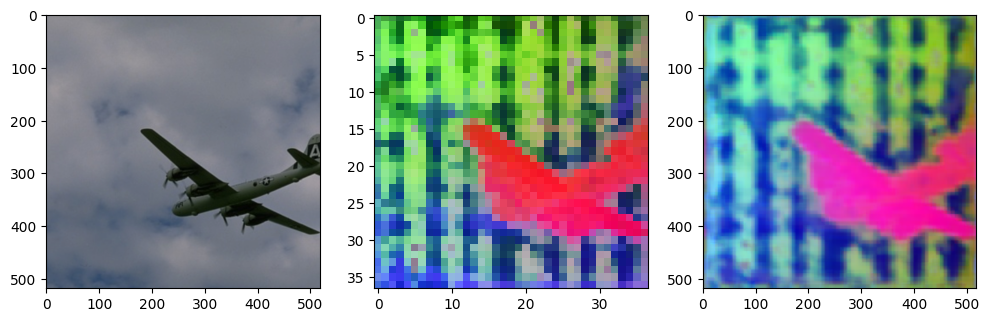

In [6]:
high_res_img = high_res_plane_pca.transpose(1, 2, 0)[:, :, :3]
normed = normalize_pca_img(high_res_img)
#print(normed[:10, :10, :3])
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

low_res_features = normalise_pca(low_res_plane_pca).reshape(PATCH_H, PATCH_W, 3)
low_res_feature_img = Image.fromarray(low_res_features)



axs[0].imshow(plane_img)
axs[1].imshow(low_res_features)
axs[2].imshow(normed[:, :, :])
titles = ["Original", "DINOv2", "Resized DINOv2", "High Res (ours)"]